In [1]:
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.merge import merge
from rasterio.features import shapes
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import os
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from osgeo import gdal
from shapely.geometry import box
from clearfell import chip_image

In [4]:
#clearfell = gpd.read_file('../../data/Scot1_felledSCDBonly.shp')
clearfell = gpd.read_file('../../data/TrainingData/CleanData_SCDB219_NFI_FelledData_atMarch2019ish.shp')

In [2]:
img_file = '../../data/s1_july_2019.tif'

In [146]:
#Prep NFI Map
nfi = gpd.read_file('https://opendata.arcgis.com/datasets/d3d7bfba1cba4a3b83a948f33c5777c0_0.geojson')
nfi = nfi[nfi['CATEGORY']=='Woodland']
nfi = nfi[nfi['IFT_IOA'].isin(['Broadleaved','Conifer','Mixed mainly broadleaved','Mixed mainly conifer'])]
nfi = nfi.to_crs('EPSG:27700')
with rio.open(img_file) as r:
    minx, miny, maxx, maxy= r.bounds
img_extent = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs='EPSG:27700')
use_nfi = gpd.overlay(nfi, img_extent, how='intersection')
use_nfi.to_file('../../data/nfi_woodland_scot1.shp', index=False)

In [4]:
#forest = gpd.read_file('../../data/nfi_woodland_scot1.shp')
forest = gpd.read_file('../../data/TrainingData/CleanData_MatureTreesData_AtMarch2019ish.shp')

In [46]:
def scale_s1_bands(img_arr):
    scale_dict = {0:(-20,-5),1:(-25,-10),2:(0,15),3:(-20,-5),4:(-25,-10),5:(0,15)}
    for i in range(6):
        min = scale_dict[i][0]
        max = scale_dict[i][1]
        img_arr[i][img_arr[i]<min]=min
        img_arr[i][img_arr[i]>max]=max
        img_arr[i]=img_arr[i]/max
    return img_arr

def standard_scale_s1_bands(img_arr):
    for i in range(img_arr.shape[0]):
        img_arr[i]=(img_arr[i] - img_arr[i].mean())/img_arr[i].std()
    return img_arr

In [115]:
"""
with rio.open(img_file) as f:
    img_arr = f.read()
    prof = f.meta
img_arr = scale_s1_bands(img_arr)
with rio.open(img_file, "w", **prof) as f:
    f.write(img_arr)
"""

In [18]:
with rio.open(img_file) as r:
    out_meta = r.meta
    bounds = r.bounds
    img_crs = r.crs.to_string()
forest_use = gpd.overlay(forest, gpd.GeoDataFrame(geometry=[box(*bounds)], crs=img_crs), how='intersection')
forest_img = rasterize(forest_use['geometry'], out_shape=([out_meta['height'],out_meta['width']]), default_value=1, fill=0, transform=out_meta['transform'])
forest_img = forest_img.astype('uint8')
out_meta.update(count=1, dtype='uint8')
with rio.open('../../data/forest_class_img.tif','w',**out_meta) as f:
    f.write(forest_img, indexes=1)

In [67]:
os.makedirs('../../data/chips/s1_imgs', exist_ok=True)
os.makedirs('../../data/chips/class_imgs', exist_ok=True)
chip_image(img_file, '../../data/chips/s1_imgs', pixel_dimensions=256, offset=128)
#chip_image('../../data/forest_class_img.tif', '../../data/chips/class_imgs', pixel_dimensions=256, offset=128)

chipping ../../data/s1_july_2019.tif to /../../data/chips/s1_imgs...


In [20]:
def remove_empty_chips(img_dir, class_img_dir, threshold=6554):
    class_imgs = [f"{class_img_dir}/{i}" for i in os.listdir(class_img_dir) if i.endswith(".tif") and "class" in i]
    s1_imgs = [f"{img_dir}/{i}" for i in os.listdir(img_dir) if i.endswith(".tif") and "s1" in i]
    print(f"{len(class_imgs)} label images and {len(s1_imgs)} s1 images initially")
    for c in class_imgs:
        with rio.open(c) as f:
            img_arr = f.read()
        if img_arr.sum() < threshold:
            idval = "_".join(c.split("_")[-2:])[:-4]
            try:
                matching = [s for s in s1_imgs if "_".join(s.split("_")[-2:])[:-4] ==idval][0]
                os.remove(matching)
            except:
                print(f"cannot remove cannot find s1 for {c}")
            os.remove(c)
    class_imgs = [i for i in os.listdir(class_img_dir) if i.endswith(".tif") and "class" in i]
    s1_imgs = [i for i in os.listdir(img_dir) if i.endswith(".tif") and "s1" in i]
    print(f"{len(class_imgs)} label images and {len(s1_imgs)} s1 images remain")

In [21]:
def check_matching(img_dir, class_img_dir):
    class_imgs = [f"{class_img_dir}/{i}" for i in os.listdir(class_img_dir) if i.endswith(".tif") and "class" in i]
    s1_imgs = [f"{img_dir}/{i}" for i in os.listdir(img_dir) if i.endswith(".tif") and "s1" in i]
    for c in class_imgs:
        idval = "_".join(c.split("_")[-2:])[:-4]
        try:
            matching = [s for s in s1_imgs if "_".join(s.split("_")[-2:])[:-4] ==idval][0]
        except:
            print(f"{idval} missing from s1")
            return False
    for s in s1_imgs:
        idval = "_".join(s.split("_")[-2:])[:-4]
        try:
            matching = [c for c in class_imgs if "_".join(c.split("_")[-2:])[:-4] ==idval][0]
        except:
            print(f"s1 {idval} missing from class")
            return False
    return True



In [22]:
remove_empty_chips(img_dir="../../data/chips/s1_imgs", class_img_dir="../../data/chips/class_imgs")

7488 label images and 7488 s1 images initially
682 label images and 682 s1 images remain


In [23]:
check_matching(img_dir="../../data/chips/s1_imgs", class_img_dir="../../data/chips/class_imgs")

True

In [47]:
def read_img(img):
    with rio.open(img) as f:
        return f.read()

def img_list_to_np(img_list, scale=False):
    img_features = [read_img(f) for f in img_list]
    if scale:
        img_features = [scale_s1_bands(i) for i in img_features]
    img_features = [reshape_as_image(i) for i in img_features]
    return np.stack(img_features, axis=0)

s1_chips = img_list_to_np(sorted([f"../../data/chips/s1_imgs/{f}" for f in os.listdir("../../data/chips/s1_imgs/") if f.endswith(".tif")]), scale=True)

class_chips = img_list_to_np(sorted([f"../../data/chips/class_imgs/{f}" for f in os.listdir("../../data/chips/class_imgs/") if f.endswith(".tif")]))


train_X, valid_X, train_y, valid_y = train_test_split(s1_chips, class_chips)

np.savez_compressed('../../data/chips/chip_images.npz', train_X=train_X, valid_X=valid_X, train_y=train_y, valid_y=valid_y)


In [61]:
#Convert the numpy arrays to tensorflow for each function to put into batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_X, valid_y))

train_dataset = train_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)


In [133]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[256,256,6]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get('adam'), 
		loss=losses.get('binary_crossentropy'),
		metrics=[metrics.get(metric) for metric in ['Precision','Recall']])

	return model

Text(0.5, 1.0, 'class_y')

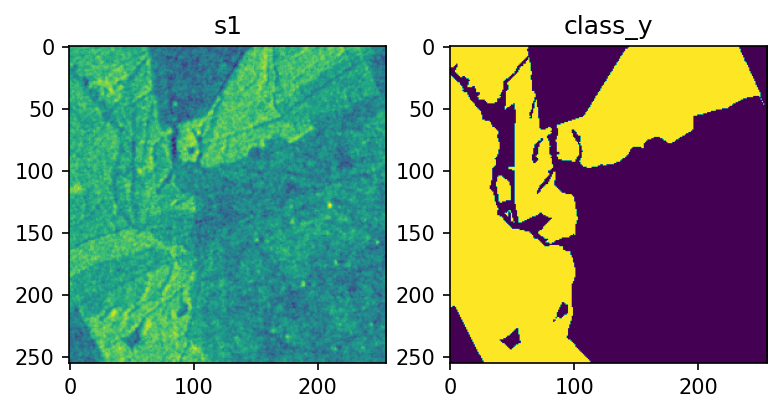

In [36]:
random_idx = random.randint(0, valid_X.shape[0])

plt.rcParams['figure.dpi'] = 150
f, axarr = plt.subplots(1,2)
axarr[0].imshow(valid_X[random_idx,:,:,1])
axarr[0].set_title('s1')
axarr[1].imshow(valid_y[random_idx,:,:,:])
axarr[1].set_title('class_y')

In [142]:
model = get_model()
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 32) 1760        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_135 (BatchN (None, 256, 256, 32) 128         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 256, 256, 32) 0           batch_normalization_135[0][0]    
____________________________________________________________________________________________

In [143]:
#Fit the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=20, batch_size=16, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/20
33/33 [==============================] - 282s 8s/step - loss: 0.3499 - precision_5: 0.7455 - recall_5: 0.7432 - val_loss: 1.9084 - val_precision_5: 0.2895 - val_recall_5: 0.1063
Epoch 2/20
33/33 [==============================] - 261s 8s/step - loss: 0.2078 - precision_5: 0.8475 - recall_5: 0.8690 - val_loss: 0.6489 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/20
33/33 [==============================] - 259s 8s/step - loss: 0.1932 - precision_5: 0.8579 - recall_5: 0.8703 - val_loss: 0.8159 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/20
33/33 [==============================] - 275s 8s/step - loss: 0.1844 - precision_5: 0.8666 - recall_5: 0.8742 - val_loss: 0.7502 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00


In [37]:
model = tf.keras.models.load_model('../../data/model')

In [63]:
model.evaluate(validation_dataset)

11/11 [==============================] - 19s 2s/step - loss: 0.2088 - precision_2: 0.9462 - recall_2: 0.9125


In [64]:
results = model.predict(validation_dataset)

In [65]:
def classify_img(pred_arr, threshold=0.5):
    return np.where(pred_arr>=0.5,1,0)

Text(0.5, 1.0, 'predicted')

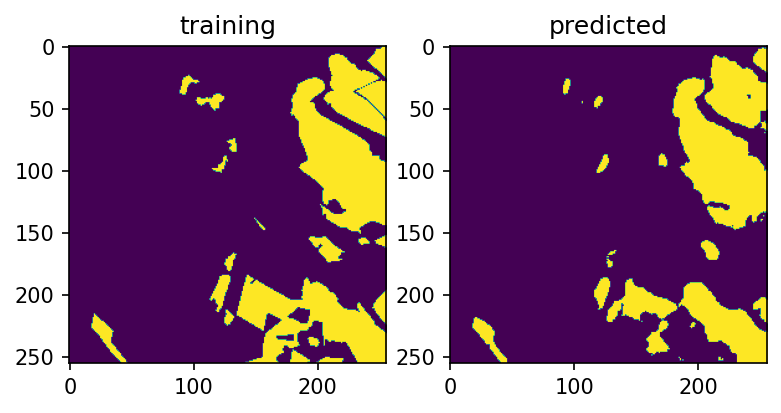

In [66]:
random_idx = random.randint(0, valid_y.shape[0])

plt.rcParams['figure.dpi'] = 150
f, axarr = plt.subplots(1,2)
axarr[0].imshow(valid_y[random_idx,:,:,:])
axarr[0].set_title('training')
axarr[1].imshow(classify_img(results[random_idx]))
axarr[1].set_title('predicted')

In [ ]:
def get_pixels_clipped(poly, img):
    with rio.open(img) as r:
        return mask(r, poly, crop=True)

In [80]:
def classify_chips(cnn_model, chips_dir, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    chips = [f"{chips_dir}/{i}" for i in os.listdir(chips_dir) if i.endswith(".tif")]
    for i, c in enumerate(chips):
        id_val = "_".join(c.split("_")[-2:])[:-4]
        with rio.open(c) as r:
            img_arr = r.read()
            out_meta = r.meta
        img_arr = scale_s1_bands(img_arr)
        img_arr = reshape_as_image(img_arr)
        img_arr = np.expand_dims(img_arr, axis=0)
        pred_img = cnn_model.predict(img_arr)
        pred_img = classify_img(pred_img[0])
        pred_img = pred_img.astype('uint8')
        pred_img = reshape_as_raster(pred_img)
        out_meta.update(count=1, width=pred_img.shape[1], height=pred_img.shape[2], dtype="uint8")
        with rio.open(f'{output_dir}/pred_chip_{id_val}.tif', 'w', **out_meta) as f:
            f.write(pred_img)
        if i > 0 and i % 100 ==0:
                print(f"processed {i} of {len(chips)}")




In [83]:
def mosaic_chip_max(res_chip_dir, source_img):
    res_chips = [f"{res_chip_dir}/{file}" for file in os.listdir(res_chip_dir) if file.endswith(".tif") and "chip" in file]
    with rio.open(source_img) as f:
        out_meta = f.meta
        bounds = f.bounds
    class_img, trans = merge(res_chips, method="max", precision=50, bounds=bounds)
    class_img = class_img.astype("uint8")
    out_meta.update(count=1, dtype="uint8")
    with rio.open(f"{res_chip_dir}/classified_result.tif", "w", **out_meta) as f:
        f.write(class_img[0], indexes=1)
    
    

In [81]:
classify_chips(model, "../../data/chips/s1_imgs", "../../data/chips/pred_imgs")

processed 100 of 7488
processed 200 of 7488
processed 300 of 7488
processed 400 of 7488
processed 500 of 7488
processed 600 of 7488
processed 700 of 7488
processed 800 of 7488
processed 900 of 7488
processed 1000 of 7488
processed 1100 of 7488
processed 1200 of 7488
processed 1300 of 7488
processed 1400 of 7488
processed 1500 of 7488
processed 1600 of 7488
processed 1700 of 7488
processed 1800 of 7488
processed 1900 of 7488
processed 2000 of 7488
processed 2100 of 7488
processed 2200 of 7488
processed 2300 of 7488
processed 2400 of 7488
processed 2500 of 7488
processed 2600 of 7488
processed 2700 of 7488
processed 2800 of 7488
processed 2900 of 7488
processed 3000 of 7488
processed 3100 of 7488
processed 3200 of 7488
processed 3300 of 7488
processed 3400 of 7488
processed 3500 of 7488
processed 3600 of 7488
processed 3700 of 7488
processed 3800 of 7488
processed 3900 of 7488
processed 4000 of 7488
processed 4100 of 7488
processed 4200 of 7488
processed 4300 of 7488
processed 4400 of 74

In [84]:
mosaic_chip_max("../../data/chips/pred_imgs", img_file)

In [ ]:
np.logical_not(a).astype(int)

In [ ]:
def classified_img_to_shp(img_fp)
with rio.open(img_fp) as f:
        classimg = f.read(1, masked=True).astype("uint8")
        rshapes = (
            {"properties": {"uniqueid": i}, "geometry": s}
            for i, (s, v) in enumerate(shapes(classimg, transform=f.transform))
        )
    geometry = list(rshapes)
    if len(geometry) > 0:
        polygons = gpd.GeoDataFrame.from_features(
            geometry, crs=img_meta["crs"].to_string()
        )
        polygons = dissolve_contiguous(polygons)
        if outfile is not None:
            polygons.to_file(outfile)
        return polygons
    else:
        print("no features")
        return None

In [2]:
#read class img masked to polygon
with rio.open('../../data/chips/pred_imgs/classified_result.tif') as f:
    prof = f.meta
    img_arr = f.read()
    mask = img_arr==1
    rshapes = (
    {"properties": {"uniqueid": i}, "geometry": s}
    for i, (s, v) in enumerate(shapes(img_arr, transform=prof['transform'], mask=mask))
    )
    geometry = list(rshapes)
if len(geometry) > 0:
    polygons = gpd.GeoDataFrame.from_features(geometry, crs=prof["crs"].to_string())

In [9]:
with rio.open('../../data/chips/pred_imgs/classified_result.tif') as r:
    out_meta = r.meta
    bounds = r.bounds
    img_crs = r.crs.to_string()
forest_use = gpd.overlay(forest, gpd.GeoDataFrame(geometry=[box(*bounds)], crs=img_crs), how='intersection')
results = gpd.overlay(forest_use,polygons,  how='difference')
results = results.explode()
results['area'] = results['geometry'].area 
results = results[results['area']>=5000]
results.to_file("../../data/chips/result_polygons.shp")

52897